In [3]:
# Импорт библиотек
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px
import optuna

# Установка максимального количества отображаемых строк и столбцов

pd.set_option('display.max_columns', None)  # Показать все столбцы




In [ ]:
#  Загрузка данных
df = pd.read_csv(r"data\avito_clean_final.csv")  

#  Целевая переменная
TARGET = "Цена"

#  Признаки
features = df.drop(columns=[TARGET]).columns.tolist()
cat_features = df[features].select_dtypes(include=["object", "category"]).columns.tolist()

# Рандом стейт 
random_state=42

model_results = []



In [5]:
def fit_and_save_model_results(model, model_name, df, log_target=False):
    """
    Обучает модель, вычисляет метрики и сохраняет результаты
    
    Параметры:
    model - модель для обучения
    model_name - название модели (для сохранения результатов)
    X_train - признаки обучающей выборки
    y_train - целевая переменная обучающей выборки
    X_test - признаки тестовой выборки (для предсказания)
    y_test - целевая переменная тестовой выборки (для оценки)
    log_target - использовать ли логарифмирование целевой переменной
    """
    # Инициализация списка результатов, если он не существует
    if 'model_results' not in globals():
        global model_results
        model_results = []

        #  Разделение на train / test
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[TARGET], test_size=0.2, random_state=random_state
    )
    
    if log_target:
        # Логарифмирование целевой переменной
        log_y_train = np.log1p(y_train)
        model.fit(X_train, log_y_train)
        log_y_pred = model.predict(X_test)  
        y_pred = np.expm1(log_y_pred)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  
    
    # Вычисление метрик
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-6, None))) * 100  # Защита от деления на 0
    
    # Вывод результатов
    print(f'\nModel: {model_name}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'R-squared (R^2): {r2:.4f}')
    print(f'RMSE: {rmse:.2f}')

    # Сохранение результатов
    model_results.append({
        'model_name': model_name,
        'MAE': mae,
        'R2': r2,
        'RMSE': rmse,

    })



In [6]:
def feature_importance_plot(feature_inportance):
    """
    Создает горизонтальную столбчатую диаграмму, отображающую важность признаков из модели CatBoost.
    
    Параметры:
    -----------
    feature_importance : pandas.DataFrame
        Датафрейм, содержащий значения важности признаков с двумя колонками:
        - 'Feature Id': str - названия признаков
        - 'Importances': float - значения важности для каждого признака
        
    Возвращает:

        Отображает интерактивный график plotly, но не возвращает значение   
    """
    fig = px.bar(
        feature_inportance.sort_values("Importances", ascending=True),  # перевернём для горизонтального графика
        x="Importances",
        y="Feature Id",
        orientation="h",
        title=" Важнейшие признаки (бейзлайн CatBoost)",
    )

    fig.update_layout(
        xaxis_title="Влияние",
        yaxis_title="Признак",
        height=800
    )

    fig.show()

In [7]:
#  Бейзлайн-модель с дефолтными параметрами
baseline_model = CatBoostRegressor(
    verbose=0,
    random_state=random_state,
    cat_features=cat_features
)
fit_and_save_model_results(model = baseline_model, model_name='Бейзлайн', df=df)


Model: Бейзлайн
Mean Absolute Error (MAE): 2393178.00
R-squared (R^2): 0.8487
RMSE: 3490289.69


In [8]:
# Важность признаков от бейзлайн-модели
base_importances = baseline_model.get_feature_importance(prettified=True)
top_base = base_importances.sort_values("Importances", ascending=False)
feature_importance_plot(top_base)

## Отбор признаков
Значение менее 0.5 имеют признаки: Пассажирский лифт, Есть мусоропровод, Есть консьерж, Спорт площадка,Детская площадка,Есть газ. Их информативность низкая, но поскольку это dummy переменные и часть их значений вносит больший вклад в модель удалить их нельзя(информативность по данным переменным размыта в модели и должна быть оценена в накопленном  значении) 

In [9]:
model_with_log= CatBoostRegressor(
    verbose=0,
    random_state=random_state,
    cat_features=cat_features
)
fit_and_save_model_results(model = model_with_log, model_name='Бейзлайн с логарифмированием', df=df, log_target=True)


Model: Бейзлайн с логарифмированием
Mean Absolute Error (MAE): 2326205.42
R-squared (R^2): 0.8441
RMSE: 3543010.24


# При логарифмировании целевой переменной произошло ухудшение метрик R^2 и RMSE, поэтомe при использовании Optuna возьмем обчные значения целевой переменной

In [10]:
# Важность признаков от log-модели
log_importances = model_with_log.get_feature_importance(prettified=True)
top_log = log_importances.sort_values("Importances", ascending=False)
feature_importance_plot(top_log)

### Кросс-валидация внутри CatBoost

Для подбора гиперпараметров используется встроенная функция `catboost.cv()`, 
которая проводит K-фолдовую кросс-валидацию (в данном случае 3-fold). 
Это позволяет получать устойчивую метрику RMSE и снижает риск переобучения при оптимизации.


[I 2025-08-03 15:24:05,847] A new study created in memory with name: Cat_boost_optuna


Training on fold [0/3]
Training on fold [0/3]
Training on fold [0/3]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
Training on fold [0/3]
Training on fold [0/3]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 4340638.111
bestIteration = 51

Training on fold [1/3]

bestTest = 4073139.688
bestIteration = 103

Training on fold [1/3]

bestTest = 3904220.384
bestIteration = 187

Training on fold [1/3]

bestTest = 3581005.598
bestIteration = 83

Training on fold [2/3]

bestTest = 3483364.421
bestIteration = 152

Training on fold [2/3]

bestTest = 3668094.733
bestIteration = 162

Training on fold [2/3]


[I 2025-08-03 15:24:49,875] Trial 4 finished with value: 3794027.483639628 and parameters: {'iterations': 689, 'depth': 5, 'learning_rate': 0.29926151408646895, 'l2_leaf_reg': 3.100248389909951, 'random_strength': 0.38549262674567125, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7157216214971105}. Best is trial 4 with value: 3794027.483639628.



bestTest = 3577864.755
bestIteration = 32



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 4120978.521
bestIteration = 265

Training on fold [1/3]


[I 2025-08-03 15:25:04,358] Trial 6 finished with value: 3760052.550702544 and parameters: {'iterations': 427, 'depth': 6, 'learning_rate': 0.1622342980644453, 'l2_leaf_reg': 0.27059195648316325, 'random_strength': 2.3248452978580568e-08, 'bootstrap_type': 'Bernoulli', 'subsample': 0.930287880365079}. Best is trial 6 with value: 3760052.550702544.



bestTest = 3331637.697
bestIteration = 157



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 4122537.265
bestIteration = 320

Training on fold [1/3]


[I 2025-08-03 15:25:11,921] Trial 2 finished with value: 3574154.151036117 and parameters: {'iterations': 947, 'depth': 4, 'learning_rate': 0.10578966523263557, 'l2_leaf_reg': 6.247771697970118, 'random_strength': 0.0012439764463802446, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7468980819914346}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3320224.168
bestIteration = 352



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3904638.877
bestIteration = 546

Training on fold [1/3]

bestTest = 3508978.117
bestIteration = 332

Training on fold [2/3]

bestTest = 4121513.115
bestIteration = 697

Training on fold [1/3]

bestTest = 3593855.534
bestIteration = 221

Training on fold [2/3]

bestTest = 3953334.104
bestIteration = 726

Training on fold [1/3]

bestTest = 4374295.885
bestIteration = 579

Training on fold [1/3]

bestTest = 4315633.72
bestIteration = 347

Training on fold [1/3]

bestTest = 4510655.557
bestIteration = 532

Training on fold [1/3]

bestTest = 3466195.991
bestIteration = 547

Training on fold [2/3]


[I 2025-08-03 15:26:39,698] Trial 7 finished with value: 3659491.955069206 and parameters: {'iterations': 766, 'depth': 6, 'learning_rate': 0.06549750325326545, 'l2_leaf_reg': 0.20351646398848625, 'random_strength': 0.001072593750889413, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9330398425154913}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3330510.329
bestIteration = 383



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3603056.074
bestIteration = 725

Training on fold [2/3]


[I 2025-08-03 15:27:03,770] Trial 8 finished with value: 3593449.964421813 and parameters: {'iterations': 548, 'depth': 4, 'learning_rate': 0.018598047126999872, 'l2_leaf_reg': 1.1739703225796891, 'random_strength': 0.03244595711278904, 'bootstrap_type': 'Bernoulli', 'subsample': 0.956112221586774}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3409207.537
bestIteration = 547



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3626148.365
bestIteration = 347

Training on fold [2/3]

bestTest = 3954994.509
bestIteration = 378

Training on fold [1/3]

bestTest = 3556563.212
bestIteration = 697

Training on fold [2/3]

bestTest = 4057612.525
bestIteration = 465

Training on fold [1/3]


[I 2025-08-03 15:27:32,045] Trial 1 finished with value: 3694533.49912584 and parameters: {'iterations': 554, 'depth': 7, 'learning_rate': 0.03487636426800474, 'l2_leaf_reg': 0.3033702511420161, 'random_strength': 0.45881322343215597, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8455652616692412}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3360164.953
bestIteration = 480



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


[I 2025-08-03 15:27:36,908] Trial 10 finished with value: 3683889.8050012183 and parameters: {'iterations': 727, 'depth': 3, 'learning_rate': 0.010948669148065492, 'l2_leaf_reg': 1.2052212456895122, 'random_strength': 6.352982840867135e-09, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5172429095569262}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3495093.025
bestIteration = 726



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3939805.522
bestIteration = 257

Training on fold [1/3]

bestTest = 3936764.752
bestIteration = 155

Training on fold [1/3]

bestTest = 3627085.429
bestIteration = 378

Training on fold [2/3]

bestTest = 3663800.902
bestIteration = 465

Training on fold [2/3]

bestTest = 3647524.281
bestIteration = 579

Training on fold [2/3]

bestTest = 3469660.506
bestIteration = 129

Training on fold [2/3]


[I 2025-08-03 15:28:07,501] Trial 9 finished with value: 3796806.802976612 and parameters: {'iterations': 348, 'depth': 7, 'learning_rate': 0.017139487851472623, 'l2_leaf_reg': 0.1401981702834649, 'random_strength': 9.049143589421929e-07, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6976486926219789}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3448638.324
bestIteration = 347



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3497435.457
bestIteration = 337

Training on fold [2/3]


[I 2025-08-03 15:28:15,284] Trial 14 finished with value: 3609659.6427091695 and parameters: {'iterations': 521, 'depth': 4, 'learning_rate': 0.09246240601070828, 'l2_leaf_reg': 0.2403334885888479, 'random_strength': 2.1770386316922408e-05, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8291198058876286}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3390468.113
bestIteration = 113



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


[I 2025-08-03 15:28:23,512] Trial 13 finished with value: 3647774.854044951 and parameters: {'iterations': 990, 'depth': 3, 'learning_rate': 0.045651064820327235, 'l2_leaf_reg': 1.3377069659300471, 'random_strength': 3.708848490907758e-05, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9506391961594002}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3493758.317
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


[I 2025-08-03 15:28:33,491] Trial 12 finished with value: 3750495.4722588994 and parameters: {'iterations': 466, 'depth': 3, 'learning_rate': 0.012957865960953397, 'l2_leaf_reg': 1.0508179238163045, 'random_strength': 6.210224130852569e-09, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7094771816801351}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3529099.236
bestIteration = 461



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3652305.072
bestIteration = 647

Training on fold [2/3]


[I 2025-08-03 15:28:41,244] Trial 11 finished with value: 3675186.504691202 and parameters: {'iterations': 379, 'depth': 5, 'learning_rate': 0.02163639141000701, 'l2_leaf_reg': 0.15154408493127175, 'random_strength': 1.0689863961338584, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9872217607142946}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3443479.576
bestIteration = 378



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 4164786.454
bestIteration = 155

Training on fold [1/3]

bestTest = 4853308.125
bestIteration = 173

Training on fold [1/3]

bestTest = 3836845.978
bestIteration = 157

Training on fold [1/3]


[I 2025-08-03 15:29:01,248] Trial 3 finished with value: 3693096.2197742523 and parameters: {'iterations': 698, 'depth': 6, 'learning_rate': 0.011014087487038254, 'l2_leaf_reg': 3.7784939801151425, 'random_strength': 2.0199390356232474e-09, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5331781598259426}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3401212.332
bestIteration = 697



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3812178.127
bestIteration = 72

Training on fold [2/3]

bestTest = 4046088.209
bestIteration = 125

Training on fold [1/3]

bestTest = 3552029.433
bestIteration = 226

Training on fold [2/3]

bestTest = 3452264.441
bestIteration = 189

Training on fold [2/3]

bestTest = 3554605.504
bestIteration = 146

Training on fold [2/3]


[I 2025-08-03 15:29:39,690] Trial 16 finished with value: 3684449.780090473 and parameters: {'iterations': 557, 'depth': 6, 'learning_rate': 0.10834785699140068, 'l2_leaf_reg': 1.2602579397628544, 'random_strength': 4.8617871200125616e-05, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7947720465515068}. Best is trial 2 with value: 3574154.151036117.



bestTest = 3320630.664
bestIteration = 136



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


[I 2025-08-03 15:29:41,251] Trial 19 finished with value: 3539421.1179592465 and parameters: {'iterations': 916, 'depth': 4, 'learning_rate': 0.1104653452300219, 'l2_leaf_reg': 6.6795576678732145, 'random_strength': 0.0046868309173475975, 'bootstrap_type': 'Bernoulli', 'subsample': 0.607635126463493}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3317447.434
bestIteration = 209



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 4330804.888
bestIteration = 375

Training on fold [1/3]

bestTest = 3914920.643
bestIteration = 133

Training on fold [1/3]


[I 2025-08-03 15:29:56,433] Trial 15 finished with value: 4086621.8063980895 and parameters: {'iterations': 918, 'depth': 8, 'learning_rate': 0.12405464598626868, 'l2_leaf_reg': 0.5087751479272029, 'random_strength': 4.8531312856150735e-05, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7732132047326636}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3581065.468
bestIteration = 182



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


[I 2025-08-03 15:30:03,093] Trial 20 finished with value: 3667453.388524259 and parameters: {'iterations': 890, 'depth': 4, 'learning_rate': 0.11294467241484586, 'l2_leaf_reg': 6.750361398333148, 'random_strength': 0.0058518518429485815, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8073728589027909}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3380959.263
bestIteration = 329



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 4048063.958
bestIteration = 101

Training on fold [1/3]

bestTest = 3480750.871
bestIteration = 191

Training on fold [2/3]

bestTest = 3977374.356
bestIteration = 94

Training on fold [1/3]


[I 2025-08-03 15:30:15,100] Trial 0 finished with value: 3839382.5675540045 and parameters: {'iterations': 580, 'depth': 8, 'learning_rate': 0.01884167985348308, 'l2_leaf_reg': 5.181136648823172, 'random_strength': 3.6844508629749316e-09, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6747640913441821}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3496249.184
bestIteration = 577



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3919845.077
bestIteration = 895

Training on fold [1/3]

bestTest = 3581849.348
bestIteration = 148

Training on fold [2/3]


[I 2025-08-03 15:30:24,468] Trial 22 finished with value: 3598883.2554549817 and parameters: {'iterations': 978, 'depth': 4, 'learning_rate': 0.1857880256189406, 'l2_leaf_reg': 9.106950709070455, 'random_strength': 0.0037579517812203816, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6144533518312941}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3371976.581
bestIteration = 113



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3430295.148
bestIteration = 162

Training on fold [2/3]


[I 2025-08-03 15:30:31,479] Trial 5 finished with value: 3916071.692004547 and parameters: {'iterations': 950, 'depth': 8, 'learning_rate': 0.026132704606667986, 'l2_leaf_reg': 0.9782657789406659, 'random_strength': 9.027033890838125e-07, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5821571590341315}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3582737.007
bestIteration = 564



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3828048.477
bestIteration = 193

Training on fold [1/3]


[I 2025-08-03 15:30:34,915] Trial 23 finished with value: 3649835.4849179233 and parameters: {'iterations': 840, 'depth': 4, 'learning_rate': 0.24105788736808784, 'l2_leaf_reg': 9.517360124009109, 'random_strength': 0.004227551092255943, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6218364938136872}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3288613.032
bestIteration = 178



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3880462.857
bestIteration = 721

Training on fold [1/3]

bestTest = 3805291.029
bestIteration = 337

Training on fold [2/3]


[I 2025-08-03 15:30:49,013] Trial 24 finished with value: 3646907.7328673624 and parameters: {'iterations': 820, 'depth': 4, 'learning_rate': 0.2135634599965326, 'l2_leaf_reg': 9.878658084752379, 'random_strength': 0.0010414994646425983, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6118690688787172}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3501353.436
bestIteration = 206



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 3491398.651
bestIteration = 166

Training on fold [2/3]

bestTest = 3954025.907
bestIteration = 277

Training on fold [1/3]


[I 2025-08-03 15:31:04,360] Trial 25 finished with value: 3608430.2827359713 and parameters: {'iterations': 817, 'depth': 4, 'learning_rate': 0.22245449074541768, 'l2_leaf_reg': 9.605192421593397, 'random_strength': 0.0007524157905245568, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6191870537574544}. Best is trial 19 with value: 3539421.1179592465.



bestTest = 3485405.295
bestIteration = 142



[I 2025-08-03 15:31:46,001] Trial 17 finished with value: 3933071.6953855357 and parameters: {'iterations': 993, 'depth': 8, 'learning_rate': 0.1245229716849046, 'l2_leaf_reg': 8.562988474764973, 'random_strength': 9.072150978105514, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5967935878438344}. Best is trial 19 with value: 3539421.1179592465.
[I 2025-08-03 15:32:02,876] Trial 28 finished with value: 3577151.9088646695 and parameters: {'iterations': 841, 'depth': 5, 'learning_rate': 0.0687087951125665, 'l2_leaf_reg': 4.1285908336810415, 'random_strength': 0.04721747788661575, 'bootstrap_type': 'Bernoulli', 'subsample': 0.849346836885618}. Best is trial 19 with value: 3539421.1179592465.
[I 2025-08-03 15:32:07,420] Trial 27 finished with value: 3631563.604846368 and parameters: {'iterations': 811, 'depth': 5, 'learning_rate': 0.06786035194699469, 'l2_leaf_reg': 2.22246226443285, 'random_strength': 8.862410009254928, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6320409894106083}. Best

Best trial: {'iterations': 916, 'depth': 4, 'learning_rate': 0.1104653452300219, 'l2_leaf_reg': 6.6795576678732145, 'random_strength': 0.0046868309173475975, 'bootstrap_type': 'Bernoulli', 'subsample': 0.607635126463493}


C:\Users\User\AppData\Local\Temp\ipykernel_23452\1109909836.py:42: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



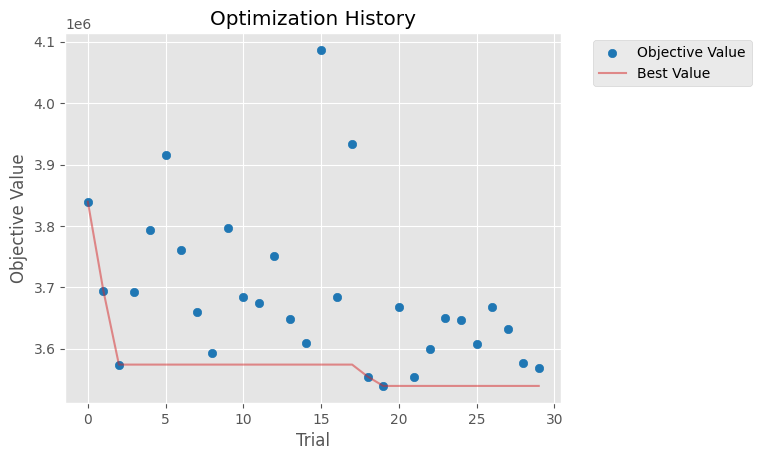

 Лучшие параметры: {'iterations': 916, 'depth': 4, 'learning_rate': 0.1104653452300219, 'l2_leaf_reg': 6.6795576678732145, 'random_strength': 0.0046868309173475975, 'bootstrap_type': 'Bernoulli', 'subsample': 0.607635126463493}
 Лучшее RMSE: 3539421.1179592465


In [12]:


def objective(trial, X_train, y_train):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "depth": trial.suggest_int("depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log = True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"]),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "verbose": 0,
        "random_state": random_state,
        "cat_features": cat_features,
        "allow_writing_files": False, 
        "subsample": trial.suggest_float("subsample", 0.5, 1)
    }

    cv_data = cv(
            Pool(X_train, y_train, cat_features=cat_features),
            params,
            fold_count=3,
            verbose=False,
            plot=True,
            early_stopping_rounds=30    #если метрика не улучшается, то через 30 шагов остновится
            
        )
    
    # Возвращаем минимальное RMSE
    return cv_data['test-RMSE-mean'].min()

def optimize_catboost(X_train, y_train, n_trials=30):
    study = optuna.create_study(study_name = 'Cat_boost_optuna',direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials, n_jobs=-1)

    print("Best trial:", study.best_trial.params) 

    plot_optimization_history(study)
    return study

def plot_optimization_history(study):
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    

# Разделение признаков и целевой переменной
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[TARGET], test_size=0.2, random_state=random_state)

# Оптимизация гиперпараметров
study = optimize_catboost(X_train, y_train)

#  Лучшие параметры и метрика
print(" Лучшие параметры:", study.best_params)
print(" Лучшее RMSE:", study.best_value)


In [ ]:
import plotly.graph_objects as go

# Извлекаем историю значений
trials = study.trials_dataframe()
trials = trials[trials["state"] == "COMPLETE"]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=trials["number"],
    y=trials["value"],
    mode="lines+markers",
    name="RMSE per trial"
))

fig.update_layout(
    title=" История оптимизации (Optuna)",
    xaxis_title="Номер итерации (trial)",
    yaxis_title="RMSE",
    height=400,
    width=800
)

fig.show()


In [13]:
best_params = study.best_params
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train, cat_features=cat_features)
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
mape_best = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100

print(f" Улучшеный RMSE: {rmse_best:.2f}")
print(f" Улучшеный R²: {r2_best:.4f}")
print(f" Улучшеный MAE: {mae_best:.4f}")


0:	learn: 7846090.9471379	total: 19.5ms	remaining: 17.9s
1:	learn: 7354164.0181974	total: 36.4ms	remaining: 16.6s
2:	learn: 6941181.2923899	total: 56.8ms	remaining: 17.3s
3:	learn: 6589417.9702061	total: 78.4ms	remaining: 17.9s
4:	learn: 6264464.9052619	total: 97.1ms	remaining: 17.7s
5:	learn: 6003318.6177632	total: 111ms	remaining: 16.8s
6:	learn: 5753943.5242946	total: 129ms	remaining: 16.7s
7:	learn: 5534403.5246615	total: 147ms	remaining: 16.7s
8:	learn: 5345491.3430042	total: 172ms	remaining: 17.3s
9:	learn: 5162068.3639080	total: 197ms	remaining: 17.8s
10:	learn: 4968970.8671599	total: 218ms	remaining: 17.9s
11:	learn: 4811101.9669217	total: 239ms	remaining: 18s
12:	learn: 4680768.7870888	total: 266ms	remaining: 18.5s
13:	learn: 4560206.8018360	total: 288ms	remaining: 18.6s
14:	learn: 4427923.2366343	total: 306ms	remaining: 18.4s
15:	learn: 4320767.5851843	total: 327ms	remaining: 18.4s
16:	learn: 4216472.6420222	total: 346ms	remaining: 18.3s
17:	learn: 4124119.2882556	total: 366m

In [14]:
print(f" Улучшеный RMSE: {rmse_best:.2f}")
print(f" Улучшеный R²: {r2_best:.4f}")
print(f" Улучшеный MAE: {mae_best:.4f}")


 Улучшеный RMSE: 3556774.02
 Улучшеный R²: 0.8429
 Улучшеный MAE: 2361786.0767


In [15]:
final_model = CatBoostRegressor(cat_features =cat_features, verbose=0,**best_params)
final_model.fit(df.drop(TARGET, axis=1), df[TARGET])

In [16]:
joblib.dump(final_model, 'property_model.pkl')

['property_model.pkl']

## Выводы

- Модель `CatBoostRegressor` показала высокую точность на отложенной выборке (R² ≈ 0.84).
- Предварительная очистка выбросов, отбор и конструирование признаков улучшили качество модели.
- Использован hold-out подход. Для повышения стабильности применена кросс-валидация.
- Полученная модель может быть применена для оценки рыночной стоимости квартиры по входным признакам.


<!-- from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

df = pd.read_csv("avito_clean_final.csv")  # путь к твоему файлу
TARGET = "Цена"
features = df.drop(columns=[TARGET]).columns.tolist()
cat_features = df[features].select_dtypes(include=["object"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(df[features], df[TARGET], test_size=0.2, random_state=42)

def evaluate_model(X_tr, X_te, y_tr, y_te, cat_feats, log_target=False, label=""):
    if log_target:
        y_tr_log = np.log1p(y_tr)
        model = CatBoostRegressor(verbose=0, random_state=42, cat_features=cat_feats)
        model.fit(X_tr, y_tr_log)
        y_pred = np.expm1(model.predict(X_te))
    else:
        model = CatBoostRegressor(verbose=0, random_state=42, cat_features=cat_feats)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

    rmse = mean_squared_error(y_te, y_pred, squared=False)
    r2 = r2_score(y_te, y_pred)
    mape = np.mean(np.abs((y_te - y_pred) / np.clip(y_te, 1e-6, None))) * 100

    print(f"📊 {label}")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ R²: {r2:.4f}")
    print(f"✅ MAPE: {mape:.2f}%")
    print("-" * 40)
    return model, y_pred

model_raw, y_pred_raw = evaluate_model(X_train, X_test, y_train, y_test, cat_features, log_target=False, label="Raw Target")
model_log, y_pred_log = evaluate_model(X_train, X_test, y_train, y_test, cat_features, log_target=True, label="Log-Transformed Target") -->
